# 1. Goals
In this notebook I'll attempt to build models to correctly predict the topic of the article. The techniques I'll use will include `Tf-idf` and `BOW` Analysis for feature-extraction, and `Unsupervised Learning` (Sklearn library) for clustering.

# 2. Introduction to DataSet
**From:** [snapcrack/all-the-news](https://www.kaggle.com/snapcrack/all-the-news)

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.
The original source on [kaggle.com](https://www.kaggle.com) contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications.

# Step: Import libraries

In [1]:
import os
# --------- Data processing --------- #
import pandas as pd
import numpy as np
from itertools import islice
# --------- Gensim --------- #
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaMulticore, CoherenceModel
from gensim.models.wrappers import LdaMallet
# --------- Visualization --------- #
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
import plotly.express as px

# Step: Extract & show data

In [2]:
"""
If random_data_sample is Ture you can shuffle 10_000 from each dataset
"""
datasets_path = [
    'data/articles1.csv',
    'data/articles2.csv',
]
random_data_sample = False
dataframes = []
for file in datasets_path:
    df = pd.read_csv(file)
    df = df['content']
    if random_data_sample:
        choices = np.random.choice(range(49999),
                                   10000,
                                   replace=False,)
        df = df[choices]
    dataframes.append(df)
news = pd.concat(dataframes, ignore_index=True)

In [3]:
news.describe()

count             99999
unique            99488
top       advertisement
freq                 42
Name: content, dtype: object

In [4]:
print('number of nan value: ', news.isna().sum())
print('Head of data:\n',news.head())
print('\nTail of data:\n',news.tail())

number of nan value:  0
Head of data:
 0    WASHINGTON  —   Congressional Republicans have...
1    After the bullet shells get counted, the blood...
2    When Walt Disney’s “Bambi” opened in 1942, cri...
3    Death may be the great equalizer, but it isn’t...
4    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

Tail of data:
 99994    There have been many proposed solutions to the...
99995    Maybe I feel like August won’t let go of me, b...
99996    Diana Marcela, 28, has spent 13 years with Far...
99997    This Christmas break, for anybody steeped in t...
99998    Brian Nesbitt’s therapist made a suggestion in...
Name: content, dtype: object


# Step: pre-process data

I use various libraries to perform this cleaning

- Remove extra items from the text (e.g mail address, numbers, whitespace)
- Tokenize text (Each text a list and each word a index of this list)
- Make bigram words (A word for two words that are often repeated)

In [5]:
def simple_preprocess(row: str) -> list:
    import re
    from textblob import Word
    from string import punctuation
    from nltk import word_tokenize
    from nltk.stem.snowball import SnowballStemmer
    from gensim.parsing.preprocessing import STOPWORDS
    
    
    publication = {'breitbart','cnn','talking','points',
                   'guardian','york','national','new',
                   'business','fox','review','insider',
                   'memo','times','buzzfeed',
                   'post','news','atlantic'}
    STOPWORDS = STOPWORDS | publication
    #Mail address
    row = re.sub('(\S+@\S+)(com|\s+com)', ' ', row)
    #Username
    row = re.sub('(\S+@\S+)', ' ', row)
    #punctuation and lowercase
    punctuation = str(punctuation 
                      + '\n'
                      + '—“,”‘-’'
                      + '0123456789')
    row = ''.join(word.lower() for word in row 
                  if word not in punctuation)
    #Extra whitespace
    row = re.sub('\s{1,}', ' ', row)
    #tokenize
    row = word_tokenize(row)
    #Stopwords and Lemma
    row = [Word(word).lemmatize() for word in row 
           if word not in STOPWORDS and 
           len(word) > 2]
    #Stemming
    #stemmer = SnowballStemmer(language='english')
    #row = [stemmer.stem(word) for word in row]
    
    return row

def make_ngram(data: list,
               be_trigram:bool = False) -> list:
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser

    bigram = Phrases(data, min_count=8, threshold=20)
    bigram_mod = Phraser(bigram)
    sentences = [bigram_mod[row] for row in data]
    
    if be_trigram:
        trigram = Phrases(sentences, threshold=30)
        trigram_mod = Phraser(trigram)
        sentences = [trigram_mod[row] for row in sentences]
    
    return sentences

def pos_determine(row, tags = ['N', 'J', 'V']):
    from nltk import pos_tag
    row = [word for (word, pos) in pos_tag(row)
          if pos[0] in tags]
    
    return row

def finalize_preprocess(data):
    sentences = []
    for row in data:
        text_processed = simple_preprocess(row)
        text_processed = pos_determine(text_processed, tags=['N'])
        sentences.append(text_processed)
    sentences = make_ngram(sentences, be_trigram=True)
    
    return sentences

In [6]:
%%time
data = news.values.tolist()
sentences = finalize_preprocess(data)
print('cleaned text:\n', sentences[12][0:80])

cleaned text:
 ['palm_beach_fla', 'donald_trump', 'year', 'weekend', 'opulence', 'actor', 'sylvester_stallone', 'gossip', 'page', 'fixture', 'fabio', 'crowd', 'developer', 'trump', 'resort_palm_beach', 'president', 'george_bush_ranch_crawford', 'kennebunkport', 'president', 'vacation_hawaii', 'home', 'trump', 'club', 'florida', 'week', 'home', 'city', 'eclipse', 'president', 'winter', 'house', 'intention', 'cereal', 'property', 'owner', 'government', 'serve', 'home', 'president', 'government', 'plan', 'property', 'club', 'membership', 'cost', 'figure', 'trump', 'arrival', 'palm_beach', 'elite', 'membership', 'jew', 'establishment', 'club', 'owner', 'island', 'admit', 'trump', 'victory', 'november', 'amenity', 'unique', 'club', 'chance', 'rub', 'president', 'disneyland', 'mouse', 'day', 'greene', 'developer', 'candidate', 'senate', 'florida', 'member', 'clinton', 'supporter', 'executive', 'cabinet', 'secretary']
Wall time: 48min 47s


In [7]:
dictionary = Dictionary(documents=sentences)

# add all of cleared text in a Series for easy save (.csv)
series = pd.Series((','.join(row) for row in sentences))
# store the dictionary and pre-processed, for future reference
series.to_csv('data/clean_news_Noun.csv', index=False)
dictionary.save('data/news_Noun.dict')

In [8]:
# Load pre-processed words
data = pd.read_csv('data/clean_news_Noun.csv',
                   header=0,
                   names=['clean_content'])
data = data['clean_content']
data.dropna(inplace=True)
sentences = [row.split(',') for row in data]

# Load dictionary
dictionary = Dictionary.load('data/news_Noun.dict')
# Checking dictionary loaded
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 access
1 administration
2 ally
3 appeal
4 appropriation
5 approval


### removes all tokens in the dictionary that are:
- Less frequent than 5 documents
- More frequent than 65% documents
- Keep only the first 150_000 most frequent tokens.

In [9]:
print('len dictionary before filtering: ',len(dictionary))
dictionary.filter_extremes(no_below=5, no_above=0.65, keep_n=150_000)
print('len dictionary after filtering: ',len(dictionary))
# dictionary from words and frequency
word2freq = {dictionary[id_]: freq 
             for id_, freq in dictionary.cfs.items()}
#sort words frequency
word2freq = dict(sorted(word2freq.items(),
                        key=lambda item: item[1],
                        reverse=True))

len dictionary before filtering:  218410
len dictionary after filtering:  74544


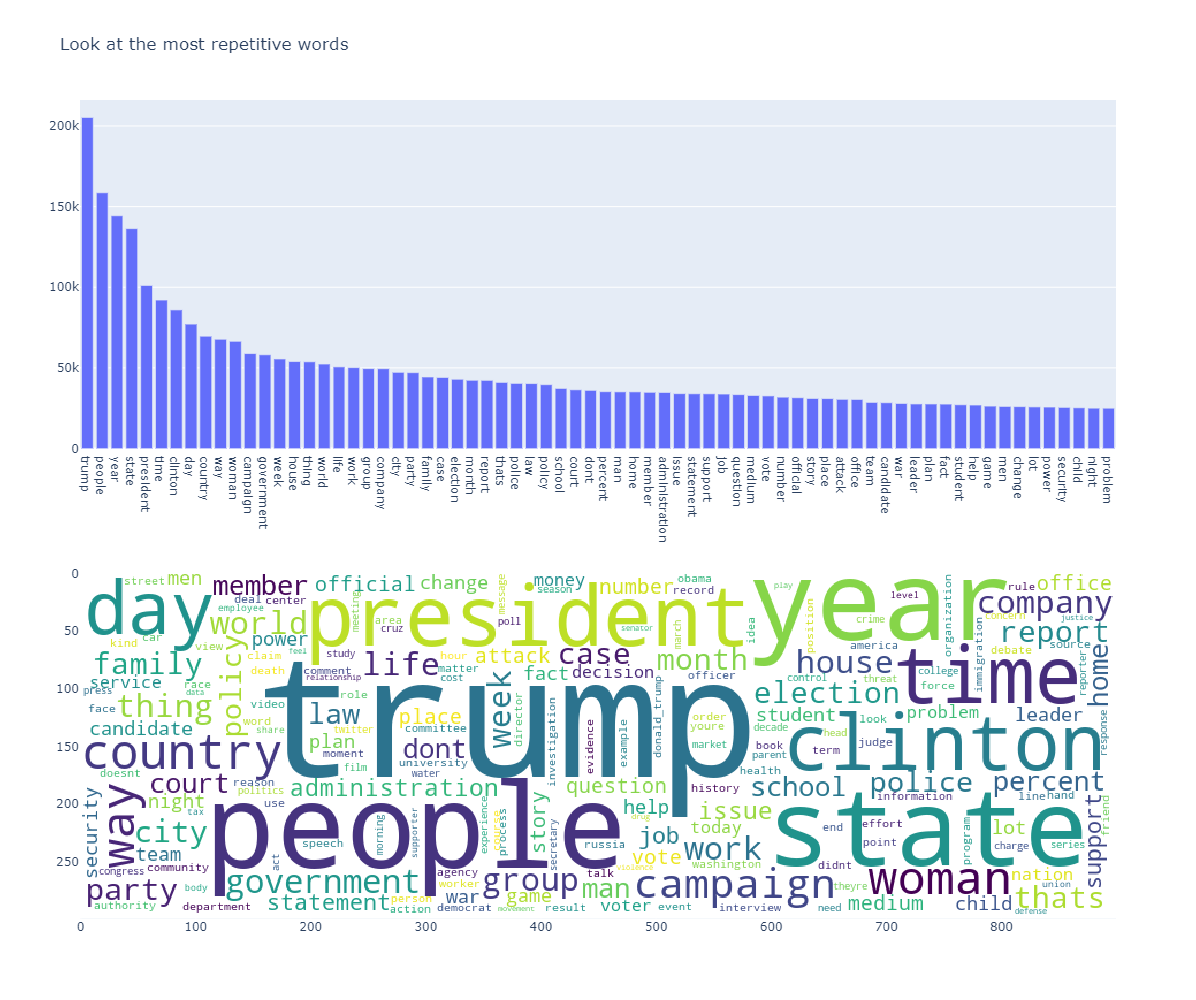

In [10]:
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "bar"}], [{"type": "image"}]],
)

most_freq = dict(islice(word2freq.items(), 70))
X_fig = list(most_freq.keys())
y_fig = list(most_freq.values())

fig.add_trace(go.Bar(x=X_fig, y=y_fig),
              row=1, col=1)


wordcloud = WordCloud(width=900,
                      height=300,
                      background_color='white',)
cloud = wordcloud.generate_from_frequencies(word2freq)

fig.add_trace(px.imshow(cloud).data[0],
              row=2, col=1)

fig.update_layout(height=1000,
                  width=1200,
                  title_text="Look at the most repetitive words",)
fig.show()

# Step: feature extraction

for topic modeling we use 2 feature-extraction `Tf-idf` and `Bag-of-word` after this work, see result and choice best method 

In [11]:
# Create the Bag-of-words model for each document
bow_corpus = [dictionary.doc2bow(doc) for doc in sentences]
# Create tf-idf model for each document
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# Preview BOW, tf-idf for our sample preprocessed document
document_n = 180
bow_doc_x = bow_corpus[document_n]
tfidf_doc_x = tfidf_corpus[document_n]
for i in range(20):
    print(f'Word {bow_doc_x[i][0]} "{dictionary[bow_doc_x[i][0]]}"', end=' ')
    print(f'appears {bow_doc_x[i][1]} time. with {tfidf_doc_x[i][1]:.5f} frequency')

Word 68 "jan" appears 1 time. with 0.06663 frequency
Word 85 "month" appears 1 time. with 0.02066 frequency
Word 119 "sue" appears 1 time. with 0.07483 frequency
Word 125 "time" appears 1 time. with 0.01238 frequency
Word 137 "year" appears 2 time. with 0.01945 frequency
Word 251 "crime" appears 1 time. with 0.04084 frequency
Word 259 "day" appears 2 time. with 0.03005 frequency
Word 261 "death" appears 1 time. with 0.03453 frequency
Word 354 "hour" appears 1 time. with 0.03136 frequency
Word 395 "man" appears 1 time. with 0.02654 frequency
Word 447 "period" appears 1 time. with 0.04383 frequency
Word 552 "studio" appears 1 time. with 0.06434 frequency
Word 591 "video" appears 3 time. with 0.11360 frequency
Word 645 "career" appears 1 time. with 0.04210 frequency
Word 647 "character" appears 1 time. with 0.04830 frequency
Word 674 "director" appears 1 time. with 0.03485 frequency
Word 677 "documentary" appears 1 time. with 0.08920 frequency
Word 698 "film" appears 1 time. with 0.04792 

# Step: Create model
## Latent Dirichlet Allocation

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

* Reference: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [17]:
def coherence_n_topics(
    id2word, corpus, texts,
    number_of_topics: list
):
    os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
    mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'

    coherence_acc = []
    model_difference_topic_num = []
    
    for num_topics in number_of_topics:
        model = LdaMallet(
            mallet_path,
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
        )
        
        model_difference_topic_num.append(model)
        
        coherencemodel = CoherenceModel(
            model=model, texts=texts,
            dictionary=id2word
        )
        
        coherence_acc.append(coherencemodel.get_coherence())

    return model_difference_topic_num, coherence_acc

In [37]:
models, coherence_accuracy = coherence_n_topics(
    dictionary, tfidf_corpus, sentences, list(range(2, 33, 4))
)

C:\Users\omidforoqi\AppData\Roaming\Python\Python38\site-packages\gensim\models\wrappers\ldamallet.py:379: RuntimeWarning:

invalid value encountered in true_divide



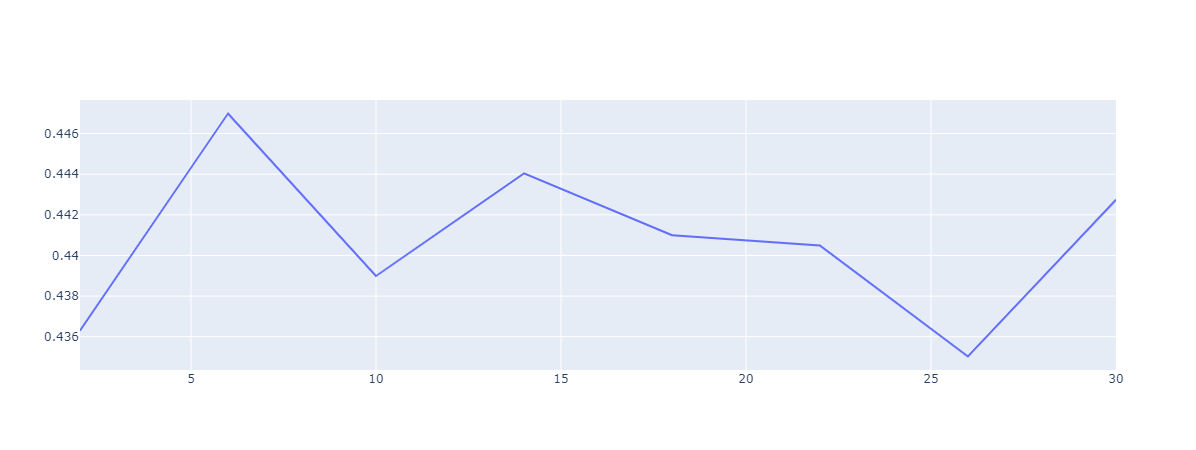

In [48]:
go.Figure(
    go.Scatter(
        x=list(range(2, 33, 4)),
        y=coherence_accuracy,
        mode='lines',
    )
)

In [12]:
%%time
lda_model = LdaMulticore(
    corpus=tfidf_corpus, num_topics=9,
    id2word=dictionary, workers=3,
    chunksize=8000, passes=20,
    iterations=500,
)
    
coherence_model = CoherenceModel(
    model=lda_model, texts=sentences,
    dictionary=dictionary, coherence='c_v',
)

print('Coherence Score: ', coherence_model.get_coherence())

Coherence Score:  0.5637402355950951
Wall time: 35min 1s


In [ ]:
# save created model
lda_model_b9.save('data/model_b9', ignore=('state', 'dispatcher'))
lda_model_t9.save('data/model_t9', ignore=('state', 'dispatcher'))

# Step: visualisation
after we build LDA model, need to visualize this for show better result. 
the easiest approch is to use `pyLDAvis` package, with less than a few line code we have a good visualisation.

In [ ]:
def visualisation(lda, corpus, dictionary):
    import pyLDAvis
    from pyLDAvis.gensim import prepare
    vis = prepare(lda, corpus, dictionary)
    return pyLDAvis.show(vis)

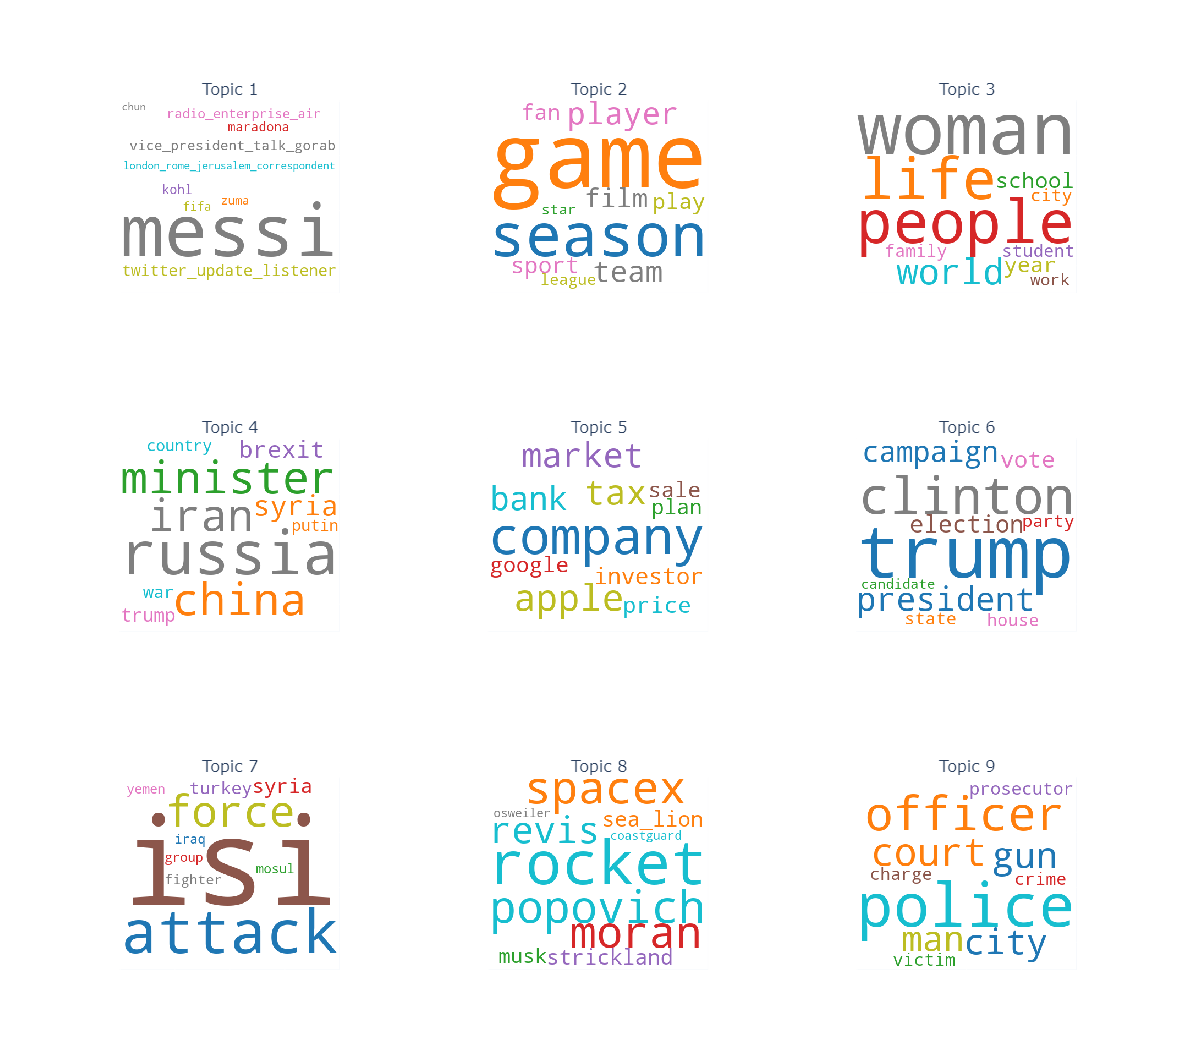

In [50]:
topics = lda_model.show_topics(
    num_words=10, formatted=False
)

cloud = WordCloud(background_color='white',
                  width=400,
                  height=350,
                  max_words=20,
                  colormap='tab10',
                  prefer_horizontal=1.0)

fig = make_subplots(3, 3,
                    subplot_titles=tuple(
                        f'Topic {n+1}' for n in range(9)
                    ))
for n in range(9):
    topic_words = dict(topics[n][1])
    cloud.generate_from_frequencies(topic_words,
                                    max_font_size=300)
    fig.add_trace(px.imshow(cloud).data[0],
                  row=int(n/3)+1, col=n%3+1)

fig.update_layout(height=1050, width=1200,
                  coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()